In [1]:
from matplotlib import rc
from inspect import signature
from IPython.display import display
from datetime import datetime
import numpy as np
import pandas as pd
import mglearn
import graphviz
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
import datetime
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action="ignore")
%matplotlib notebook
%matplotlib inline
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import itertools
import statsmodels.api as sm
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [24]:
df = pd.read_csv("data_final.csv")
# df['date'] = pd.to_datetime(df['date'], format = "%Y%m")
df = df.sort_index() #mine was not always sorted
df = df.set_index('date')
df.index = (pd.date_range(start=df.index[0], end=df.index[-1], freq='MS'))

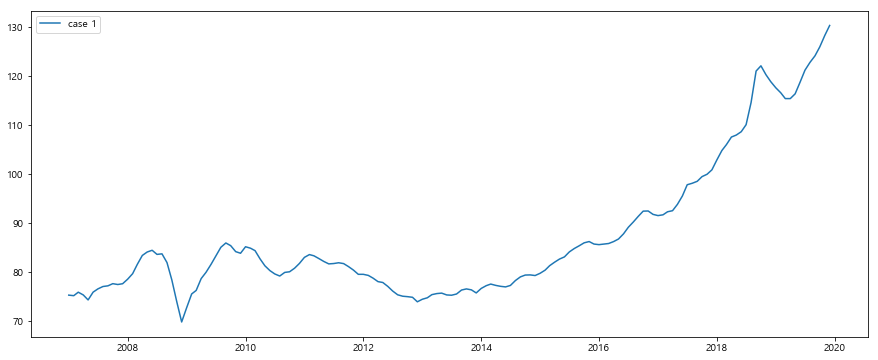

In [25]:
plt.figure(figsize=(15, 6))
i = 1
plt.plot(df.SPI, label='case {}'.format(i))
plt.legend()

In [26]:
#AR 자기 회귀
#AR 모형의 Lag : P
#MA 모형의 Lag :q
#차분(Difference)횟수 : d

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [28]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [29]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [30]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df["SPI"], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [31]:
# AIC 한번에 찾아주는 코드
select_candi = 10000000
param_candi = ( 0, 0, 0 )
param_seasonal_candi = ( 0, 0, 0)

count=0
end_count = len(pdq)

for param in pdq:   
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX( df['SPI'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                           )
            results = mod.fit()
            count += 1
            if count <= 5:
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            if results.aic < select_candi:
                select_candi = results.aic
                param_candi = param
                param_seasonal_candi = param_seasonal
        except:
            continue
            
print(param_candi, param_seasonal_candi, select_candi)    

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1831.2108994647438
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1541.2875893924083
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:977.3949795268104
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:876.987775779143
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:933.0380006950894


C:\app\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\app\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\app\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\app\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\app\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 1, 1) (0, 1, 1, 12) 344.18675867665615


In [11]:
# ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:401.4348213901941
# AIC가 낮을수록 좋다

In [32]:
mod = sm.tsa.statespace.SARIMAX(df["SPI"],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4607      0.061      7.614      0.000       0.342       0.579
ma.L1          0.4101      0.091      4.522      0.000       0.232       0.588
ma.S.L12      -0.7317      0.094     -7.768      0.000      -0.916      -0.547
sigma2         0.7696      0.079      9.727      0.000       0.615       0.925


In [33]:
pred = results.get_prediction(
    start=pd.to_datetime('2019-01-01'), end=pd.to_datetime('2019-12-01'),
    dynamic=False
)

pred_ci = pred.conf_int()

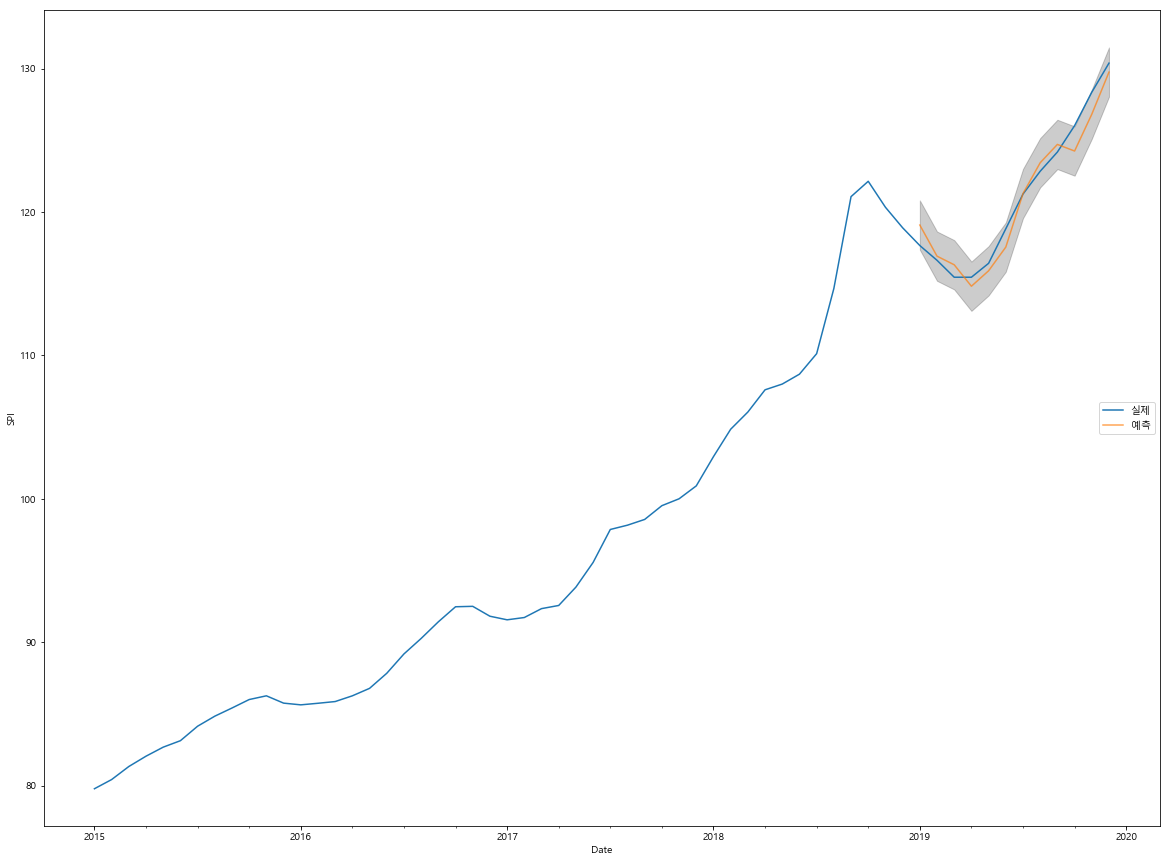

In [34]:
ax = df['SPI']['2015' : ].plot( label='실제', figsize=(20, 15) )

# 예측
pred.predicted_mean.plot(
    ax=ax,
    label='예측',
    alpha=.7
)

ax.fill_between(
    pred_ci.index,
    pred_ci['lower SPI'],
    pred_ci['upper SPI'],
    color='k',
    alpha=.2
)

ax.set_xlabel('Date')
ax.set_ylabel('SPI')
plt.legend(loc=5)

plt.show()

In [35]:
# 시계열의 예측 및 실제 값 추출
y_forecasted = pred.predicted_mean
y_truth = df['SPI']['2019-01-01' : ]

# MSE
mse = (( y_forecasted - y_truth ) ** 2).mean()
print('예측의 MSE {}'.format( round(mse, 2) ) )  

예측의 MSE 0.97


In [36]:
# 미래의 단위 예측
pred_uc = results.get_forecast( steps=12 )

# 예측의 신뢰 구간
pred_ci = pred_uc.conf_int()

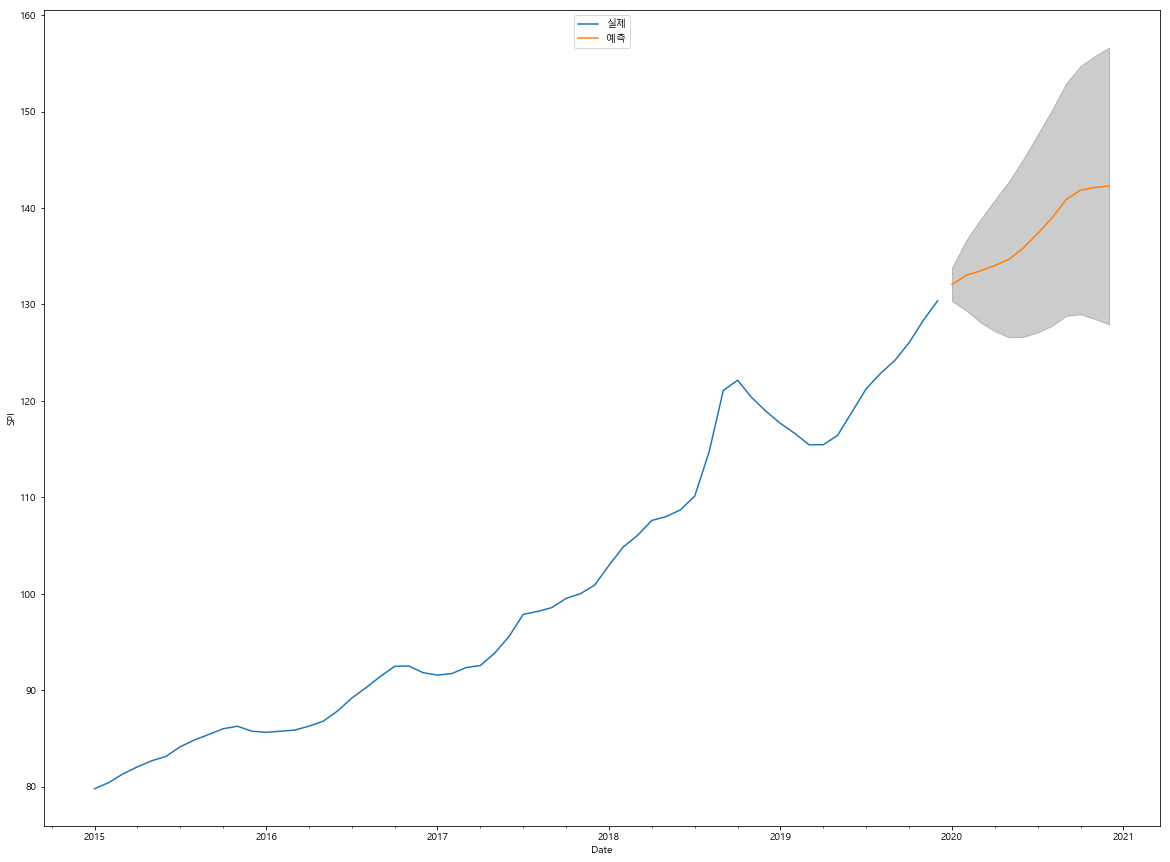

In [37]:
ax = df['SPI']['2015' : ].plot( label='실제', figsize=(20, 15) )

# 예측
pred_uc.predicted_mean.plot(
    ax=ax,
    label='예측'
)

ax.fill_between(
    pred_ci.index,
    pred_ci['lower SPI'],
    pred_ci['upper SPI'],
    color='k',
    alpha=.2
)


ax.set_xlabel('Date')
ax.set_ylabel('SPI')
plt.legend(loc=9)

plt.show()

In [38]:
pred_uc.predicted_mean

2020-01-01    132.060331
2020-02-01    133.016295
2020-03-01    133.473150
2020-04-01    134.028881
2020-05-01    134.685680
2020-06-01    135.860064
2020-07-01    137.352508
2020-08-01    138.960496
2020-09-01    140.876311
2020-10-01    141.846691
2020-11-01    142.122068
2020-12-01    142.286434
Freq: MS, dtype: float64